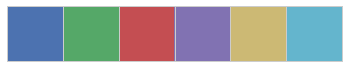

In [66]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)
sns.set()
sns.set_style("whitegrid")
reso=300
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [21]:
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.
    Richard M. Brugger, "A Note on Unbiased Estimation of the Standard Deviation", The American Statistician (23) 4 p. 32 (1969)

    values, weights -- Numpy ndarrays with the same shape.
    """
    n=len(values)
    average = np.average(values, weights=weights)
    variance = (n/(n-1.5))*np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return np.sqrt(variance),average

In [33]:
df=pd.read_csv("NED27.09.1-D-14.2.0-20170929.csv",skiprows=12)

In [34]:
df=df[np.isnan(df['redshift (z)'])] # only measurements without redshift data are useful here

In [35]:
dfa=df[np.isfinite(df.err)&(df.err!=0)] # database of reported errors
len(dfa)

278556

In [36]:
namelist=list(dfa['Galaxy ID'])
counter=collections.Counter(namelist)

In [37]:
meas=np.array(list(counter.values()))
len(meas)

176125

In [38]:
names=np.array(list(counter.keys()))

In [51]:
%%time
np.random.seed(10)
nbins=100 # 1e4 -> 4 minutes
bootp50=[] # mean error from the bootstrap for each galaxy
bootsig=[] # uncertainty of the error -> may not be a good predictor
dboot=[] # mean bootstrap distance
bootmad=[] # median absolute deviation (robust)
ecf=[]
eqd=[]
gal=[]
for i,em in zip(counter.keys(),counter.values()):
    dfilter=np.in1d(df1['Galaxy ID'],i)
    dummy=df1[dfilter]
    gal+=[i] 
    if em==1:
        bootp50+=[0] # mean error from the bootstrap for each galaxy
        bootsig+=[0] # uncertainty of the error -> may not be a good predictor
        bootmad+=[0] # median absolute deviation (robust)
        wnat,avnat = dummy['err'].iloc[0],dummy['m-M'].iloc[0]
        distwav=10**(avnat/5+1)/1e6
        dboot+=[distwav] # regular distance
        ecfi=0.461*distwav/np.sqrt((1/dummy['err']**2).sum()) # error according to cosmicflows
        ecf+=[ecfi]
        eqd+=[0]
# weighted std using D and propagated err is similar to propagated D error using weighted std on modulus and error

IndexError: single positional indexer is out-of-bounds

In [39]:
len(names[meas>1])

13342

In [41]:
len(dfa) #reported-error measurements

278556

In [42]:
df1=df1[np.in1d(df1['Galaxy ID'],names[meas>1])]

In [43]:
len(df1) #reported-error measurements with n>1

115773

In [53]:
%%time
np.random.seed(10)
nbins=10000 # 1e3 -> 1 minutes, 1e4 needs ??
bootp50=[] # mean error from the bootstrap for each galaxy
#bootsig=[] # uncertainty of the error -> may not be a good predictor
dboot=[] # mean bootstrap distance
bootmad=[] # median absolute deviation (robust)
ecf=[]
eqd=[]
gal=[]
for i in names[meas>1]:
    dfilter=np.in1d(df1['Galaxy ID'],i)
    dummy=df1[dfilter]
    gal+=[i]
    tli=[]
    for km,ke in zip(dummy['m-M'],dummy['err']):
        tli+=[list(10**(np.random.normal(km,ke,nbins)/5.+1))] # bootstrap draw for each gal
    tli=np.array(tli)
    booterr=(np.percentile(tli, 84,axis=0)-np.percentile(tli, 16,axis=0))/2 # sigma draws from bootstrap for each gal
    bootmean=np.median(tli,axis=0) # mean draws from bootstrap for each gal
############## This block should be ran for 10k draws ###############
#    mymed=np.median(tli,axis=0) #median for error of m error
#    mst=[np.median(np.abs(tli[:,kk]-mymed[kk])) for kk in range(nbins)]
#    bootmsig+=[(np.percentile(mst, 84,axis=0)-np.percentile(mst, 16,axis=0))/2e6] # error of m error
#    bootmother+=[np.median(mst)/1e6]
#####################################################################
    bootp50+=[np.median(booterr)/1e6] # mean bootstrap error
#    bootsig+=[((np.percentile(booterr, 84)-np.percentile(booterr, 16)))/2e6] # the error of the error
    bootmad+=[np.median(np.abs(tli - np.median(tli)))/1e6]
    dboot+=[np.median(bootmean)/1e6] # bootstrap mean D
    wnat,avnat = weighted_std(dummy['m-M'],1/dummy['err']**2)
    distwav=10**(avnat/5+1)/1e6
    wsti=0.461*distwav*wnat # weighted standard deviation
    ecfi=0.461*distwav/np.sqrt((1/dummy['err']**2).sum()) # error according to cosmicflows
    ecf+=[ecfi]
    eqd+=[np.sqrt(ecfi**2+wsti**2)]  

CPU times: user 7min 57s, sys: 1min 8s, total: 9min 5s
Wall time: 9min 30s


In [46]:
gal[0]

'NGC 0931'

In [56]:
d = {'Galaxy ID': names[meas>1], 'meas': meas[meas>1], 'H (Mpc)':bootp50, 'D (Mpc)':dboot,'P (Mpc)':ecf,'Q (Mpc)':eqd,'M (Mpc)':bootmad}
dfb = pd.DataFrame(data=d)
dfb.to_csv("ned_bootstrap_results.csv")

In [57]:
len(dfb)

13342

In [63]:
meas[meas>1]==2

array([False, False, False, ..., False, False,  True], dtype=bool)

In [64]:
filt=(np.array(meas[meas>1])==2)
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]

(0, 1000)

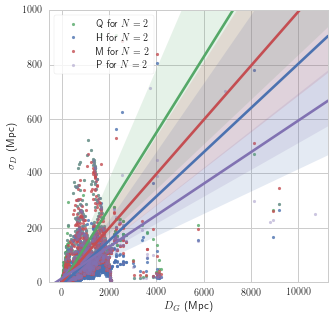

In [70]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $N=2$') # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $N=2$', scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $N=2$', scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $N=2$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.ylim(0,1000)
#plt.savefig('mnras/Nlow.pdf', dpi=reso,transparent=True)
#plt.savefig('mnras/Nlow.png', dpi=reso,transparent=True)

In [89]:
filt=(np.array(meas[meas>1])<6)
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]

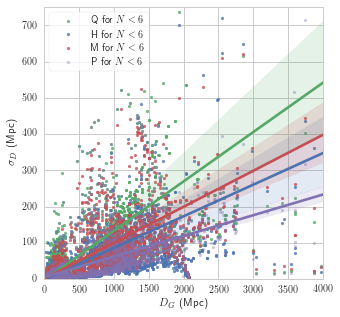

In [94]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $N<6$') # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $N<6$', scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $N<6$', scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $N<6$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(0,4000)
plt.ylim(0,750)
plt.savefig('mnras/Nlow.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/Nlow.png', dpi=reso,transparent=True)

(0, 50)

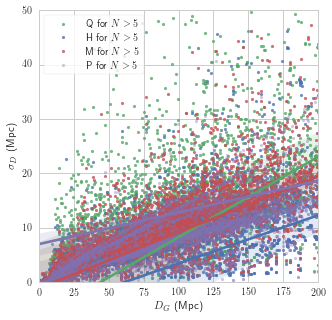

In [87]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $N>5$') # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $N>5$', scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $N>5$', scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $N>5$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(0,200)
plt.ylim(0,50)


#plt.savefig('mnras/Nlow.pdf', dpi=reso,transparent=True)
#plt.savefig('mnras/Nlow.png', dpi=reso,transparent=True)

In [98]:
filt=(np.array(meas[meas>1])>5)
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]

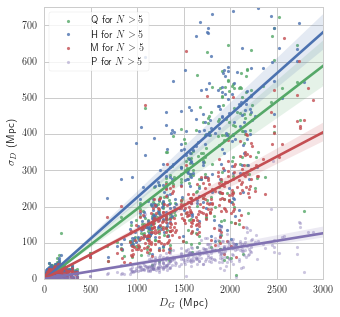

In [100]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $N>5$') # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $N>5$', scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $N>5$', scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $N>5$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(0,3000)
plt.ylim(0,750)
plt.savefig('mnras/Nhigh.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/Nhigh.png', dpi=reso,transparent=True)

(0, 100)

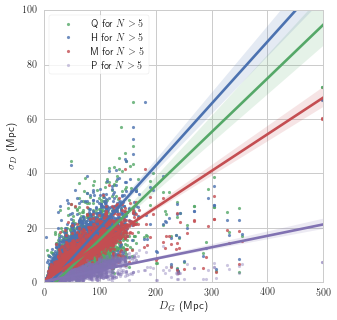

In [81]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $N>5$') # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $N>5$', scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $N>5$', scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $N>5$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(0,500)
plt.ylim(0,100)


#plt.savefig('mnras/Nlow.pdf', dpi=reso,transparent=True)
#plt.savefig('mnras/Nlow.png', dpi=reso,transparent=True)